In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot


#数据读取
features = pd.read_csv("E:\\machineLearning\\kaggle\\dataset\\temps.csv") #注意转义字符\t
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [2]:
#特征可视化与预处理
print("数据维度：", features.shape)
features.describe()
#处理时间数据
years = features['year']
months = features['month']
days = features['day']
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day))
         for year,month,day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for  date in dates]
dates[:5]

数据维度： (348, 9)


[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

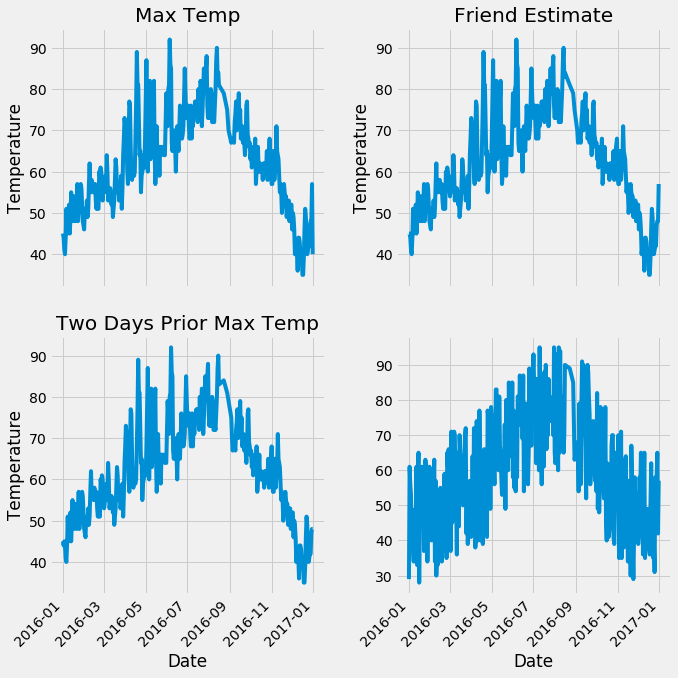

In [3]:
#绘图
warnings.filterwarnings("ignore")
#%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation=45)
ax1.plot(dates, features['actual'])
ax1.set_xlabel('');ax1.set_ylabel('Temperature');ax1.set_title('Max Temp')
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel('');ax2.set_ylabel('Temperature');ax2.set_title('Previous Max Temp')
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date');ax3.set_ylabel('Temperature');ax3.set_title('Two Days Prior Max Temp')
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date');ax2.set_ylabel('Temperature');ax2.set_title('Friend Estimate')
plt.tight_layout(pad=2)

In [4]:
#独热编码，将字符串转为计算机语言
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [5]:
#重新组合数据
labels = np.array(features['actual']) #标签
features = features.drop('actual', axis=1) #特征，从中去掉标签
feature_list = list(features.columns)
features = np.array(features)
#切分数据集
train_features, test_features, train_labels, test_labels = (
    train_test_split(features, labels, test_size=0.25, random_state=42))
print('训练集特征：', train_features.shape)
print('训练集标签：', train_labels.shape)
print('测试集特征：', test_features.shape)
print('测试集标签：', test_labels.shape)

训练集特征： (261, 14)
训练集标签： (261,)
测试集特征： (87, 14)
测试集标签： (87,)


In [6]:
#随机森林模型建立
rf = RandomForestRegressor(n_estimators=1000, random_state=42) #建模
rf.fit(train_features, train_labels) #训练
predictions = rf.predict(test_features) #预测结果
errors = abs(predictions - test_labels) #误差
mape = 100 * (errors / test_labels) #结果评估，平均绝对百分误差
print('MAPE:', np.mean(mape))

MAPE: 6.011244187972058


In [7]:
#绘制决策树模型
#修改pydot.python文件中的代码
tree = rf.estimators_[5]
export_graphviz(tree, out_file="tree.dot",
                feature_names= feature_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('E:\\machineLearning\\kaggle\\projectResult\\tree.dot')
graph.write_png('E:\\machineLearning\\kaggle\\projectResult\\tree.png') #在指定目录下生成

In [8]:
#剪枝
rf_small = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)
rf_small.fit(train_features, train_labels)
tree_small = rf_small.estimators_[5]
export_graphviz(tree_small, out_file='E:\\machineLearning\\kaggle\\projectResult\\small_tree.dot',
                feature_names=feature_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('E:\\machineLearning\\kaggle\\projectResult\\small_tree.dot')
graph.write_png('small_tree.png')

Variable:temp_1               Importance:0.7
Variable:average              Importance:0.19
Variable:day                  Importance:0.03
Variable:temp_2               Importance:0.02
Variable:friend               Importance:0.02
Variable:month                Importance:0.01
Variable:year                 Importance:0.0
Variable:week_Fri             Importance:0.0
Variable:week_Mon             Importance:0.0
Variable:week_Sat             Importance:0.0
Variable:week_Sun             Importance:0.0
Variable:week_Thurs           Importance:0.0
Variable:week_Tues            Importance:0.0
Variable:week_Wed             Importance:0.0


Text(0.5,1,'Variable Importances')

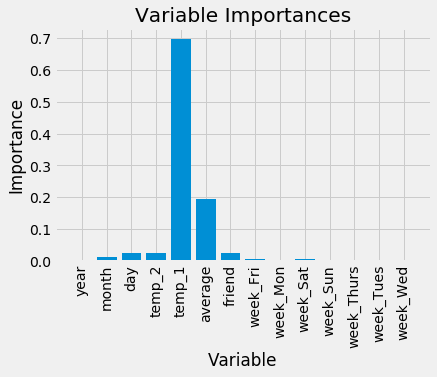

In [9]:
#特征重要性
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2))
                        for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key=lambda x : x[1], reverse=True) #排序
[print('Variable:{:20} Importance:{}'.format(*pair)) for pair in feature_importances]
#绘制成图表
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation = 'vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

In [10]:
#选择最好的特征建模
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
rf_most_important.fit(train_important, train_labels)
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
print('mape:', mape)

Mean Absolute Error: 3.92 degrees.
mape: 6.229055723613811


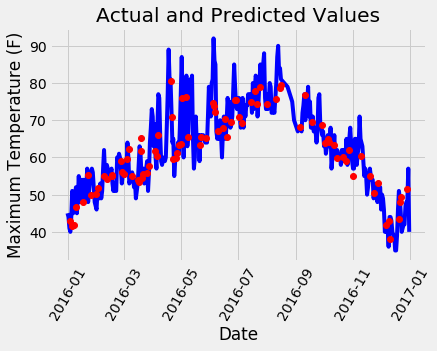

In [12]:
#评估预测值
#表格，保存日期和标签值，使用全部数据集features！
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year,month,day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
true_data = pd.DataFrame(data={'date':dates, 'actual':labels})
#表格，保存日期和预测值，使用测试集test_features！
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year,month,day in zip(years, months, days)]
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
predictions_data = pd.DataFrame(data={'date':test_dates, 'prediction':predictions})
plt.plot(true_data['date'], true_data['actual'], 'b-', label='actual') #真实值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label='prediction') #预测值
plt.xticks(rotation='60');
plt.legend
plt.xlabel('Date');plt.ylabel('Maximum Temperature (F)');plt.title('Actual and Predicted Values');